# Импорты

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy
import cvxpy 
import sympy.plotting
import array_to_latex as a2l

In [3]:
np.set_printoptions(precision=2)
sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I

In [433]:
def get_t(end_t = 100, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

In [5]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_matrix(A, C):
    obsv_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    assert np.allclose(control.obsv(A, C), obsv_m), 'Smth wrong'
    return obsv_m
        
def check_controllability_eigens(A, B):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")

def check_observability_eigens(C, A):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")

# Задание 1

In [322]:
task1_A1 = np.array([
    [1, 0, 0],
    [0, 3, 1], 
    [0, -1, 4]
])

task1_B1 = np.ones((3, 1))

task1_A2 = np.array([
    [0, 1, 0, 0],
    [-1, 0, 0, 0], 
    [0, 0, 0, 2],
    [0, 0, -2, 0]
])

task1_B2 = np.array([
    [1, 1, 0, 0],
    [0, 0, 1, 0], 
    [0, 0, 0, 1]
])

task1_C2 = np.array([[1, 1, 1]])
task1_D2 = 0

In [323]:
print(f'\[A_1 = {a2l.to_ltx(task1_A1, print_out=False)}\]')
print(f'\[A_2 = {a2l.to_ltx(task1_A2, print_out=False)}\]')
print(f'\[B_1 = {a2l.to_ltx(task1_B1, print_out=False)}\]')
print(f'\[B_2 = {a2l.to_ltx(task1_B2, print_out=False)}\]')
print(f'\[C_2 = {a2l.to_ltx(task1_C2, print_out=False)}\]')
print(f'\[D_2 = {0}\]')

\[A_1 = \begin{bmatrix}
  1.00 &  0.00 &  0.00\\
  0.00 &  3.00 &  1.00\\
  0.00 & -1.00 &  4.00
\end{bmatrix}\]
\[A_2 = \begin{bmatrix}
  0.00 &  1.00 &  0.00 &  0.00\\
 -1.00 &  0.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  2.00\\
  0.00 &  0.00 & -2.00 &  0.00
\end{bmatrix}\]
\[B_1 = \begin{bmatrix}
  1.00\\
  1.00\\
  1.00
\end{bmatrix}\]
\[B_2 = \begin{bmatrix}
  1.00 &  1.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  1.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  1.00
\end{bmatrix}\]
\[C_2 = \begin{bmatrix}
  1.00 &  1.00 &  1.00
\end{bmatrix}\]
\[D_2 = 0\]


In [324]:
check_controllability_eigens(task1_A1, task1_B1)

Eigen values of A:
   [3.5+0.87j]: controllable
   [3.5-0.87j]: controllable
   [1.+0.j]: controllable


In [325]:
eig_vals_A1 = np.linalg.eigvals(task1_A1)
eig_vals_A2 = np.linalg.eigvals(task1_A2)

In [326]:
print(eig_vals_A1, eig_vals_A2)

[3.5+0.87j 3.5-0.87j 1. +0.j  ] [0.+1.j 0.-1.j 0.+2.j 0.-2.j]


In [342]:
def get_control_by_state(A1, A2, B1, B2, C2, D2):
    K, S, E = control.lqr(A1, B1, np.eye(A1.shape[0]) * 1, np.eye(B1.shape[1]) * 5.0)
    K = -K
    P = cvxpy.Variable((A1.shape[0], A2.shape[0]))
    Y = cvxpy.Variable((B1.shape[1], A2.shape[0])) 
    prob = cvxpy.Problem(cvxpy.Minimize(0), [C2 @ P + D2 == 0, P @ A2 - A1 @ P == B1 @ Y + B2])
    print('Optimization error: ', prob.solve(solver=cvxpy.ECOS))
    K2 = Y.value - K @ P.value
    
    print(f'\[K_1 = {a2l.to_ltx(K, print_out=False)}\]')
    print(f'\[spec(A + B_1 K_1) = {a2l.to_ltx(E, print_out=False)}\]')
    print(f'\[K_2 = {a2l.to_ltx(K2, print_out=False)}\]')
    return K, K2, control.ss(A1 + B1@K, B2 + B1@K2, C2, D2)

In [343]:
ts = get_t(30)
w_ss = control.ss(task1_A2, np.zeros_like(task1_A2), np.zeros_like(task1_A2), np.zeros_like(task1_A2))
ws = control.forced_response(w_ss, X0=np.ones(task1_A2.shape[0]), T=ts).states

K1, K2, ss = get_control_by_state(task1_A1, task1_A2, task1_B1, task1_B2, task1_C2, task1_D2)
resp = control.forced_response(ss, T=ts, X0=np.ones(task1_A1.shape[0]), U=ws)

Optimization error:  0.0
\[K_1 = \begin{bmatrix}
 -6.35 & -94.35 &  84.56
\end{bmatrix}\]
\[spec(A + B_1 K_1) = \begin{bmatrix}
 -3.53 + 0.86j & -3.53 + -0.86j & -1.09 + 0.00j
\end{bmatrix}\]
\[K_2 = \begin{bmatrix}
 -0.80 & -6.74 & -31.30 &  10.72
\end{bmatrix}\]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


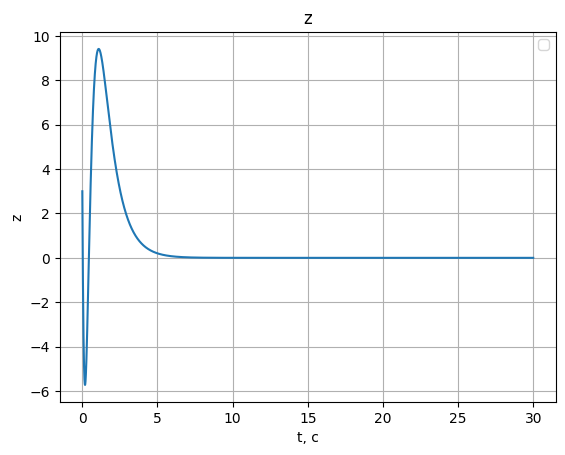

In [347]:
plt.plot(ts, resp.outputs[0])
plt.xlabel('t, c')
plt.ylabel('z')
plt.title("z")
plt.legend()
plt.grid()

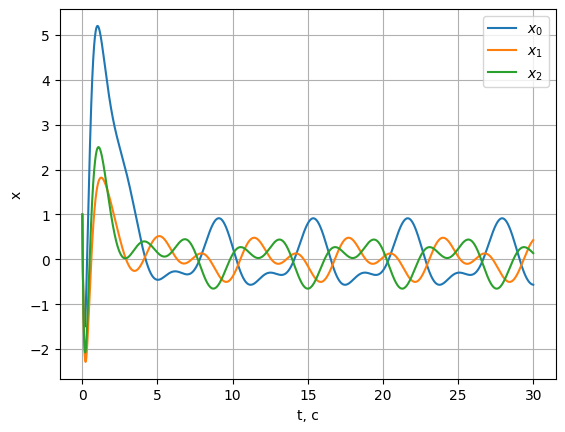

In [345]:
for i in range(task1_A1.shape[0]):
    plt.plot(ts, resp.states[i], label=f'$x_{i}$')
plt.xlabel('t, c')
plt.ylabel('x')
plt.legend()
plt.grid()

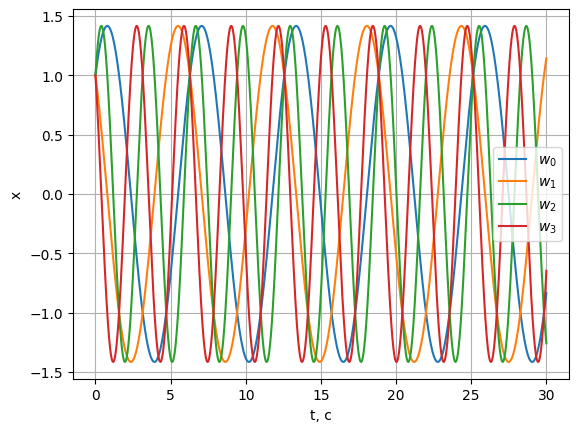

In [346]:
for i in range(task1_A2.shape[0]):
    plt.plot(ts, ws[i], label=f'$w_{i}$')
plt.xlabel('t, c')
plt.ylabel('x')
plt.legend()
plt.grid()

# Задание 2

In [352]:
task2_A1 = task1_A1
task2_B1 = task1_B1
task2_A2 = task1_A2
task2_C2 = task1_C2

In [353]:
task2_B2 = np.zeros((task2_A1.shape[0], task2_A2.shape[0]))
task2_D2 = np.array([[1, 1, 1, 1]])

In [354]:
print(f'\[A_1 = {a2l.to_ltx(task2_A1, print_out=False)}\]')
print(f'\[A_2 = {a2l.to_ltx(task2_A2, print_out=False)}\]')
print(f'\[B_1 = {a2l.to_ltx(task2_B1, print_out=False)}\]')
print(f'\[B_1 = {a2l.to_ltx(task2_B2, print_out=False)}\]')
print(f'\[C_2 = {a2l.to_ltx(task2_C2, print_out=False)}\]')
print(f'\[D_2 = {a2l.to_ltx(task2_D2, print_out=False)}\]')

\[A_1 = \begin{bmatrix}
  1.00 &  0.00 &  0.00\\
  0.00 &  3.00 &  1.00\\
  0.00 & -1.00 &  4.00
\end{bmatrix}\]
\[A_2 = \begin{bmatrix}
  0.00 &  1.00 &  0.00 &  0.00\\
 -1.00 &  0.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  2.00\\
  0.00 &  0.00 & -2.00 &  0.00
\end{bmatrix}\]
\[B_1 = \begin{bmatrix}
  1.00\\
  1.00\\
  1.00
\end{bmatrix}\]
\[B_1 = \begin{bmatrix}
  0.00 &  0.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  0.00
\end{bmatrix}\]
\[C_2 = \begin{bmatrix}
  1.00 &  1.00 &  1.00
\end{bmatrix}\]
\[D_2 = \begin{bmatrix}
  1.00 &  1.00 &  1.00 &  1.00
\end{bmatrix}\]


In [355]:
ts = get_t(30)
w_ss = control.ss(task2_A2, np.zeros_like(task2_A2), np.zeros_like(task2_A2), np.zeros_like(task2_A2))
ws = control.forced_response(w_ss, X0=np.ones(task2_A2.shape[0]), T=ts).states

K1, K2, ss = get_control_by_state(task2_A1, task2_A2, task2_B1, task2_B2, task2_C2, task2_D2)

resp = control.forced_response(ss, T=ts, X0=np.ones(task2_A1.shape[0]), U=ws)

Optimization error:  0.0
\[K_1 = \begin{bmatrix}
 -6.35 & -94.35 &  84.56
\end{bmatrix}\]
\[spec(A + B_1 K_1) = \begin{bmatrix}
 -3.53 + 0.86j & -3.53 + -0.86j & -1.09 + 0.00j
\end{bmatrix}\]
\[K_2 = \begin{bmatrix}
  1.19 & -0.42 &  0.84 &  1.41
\end{bmatrix}\]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


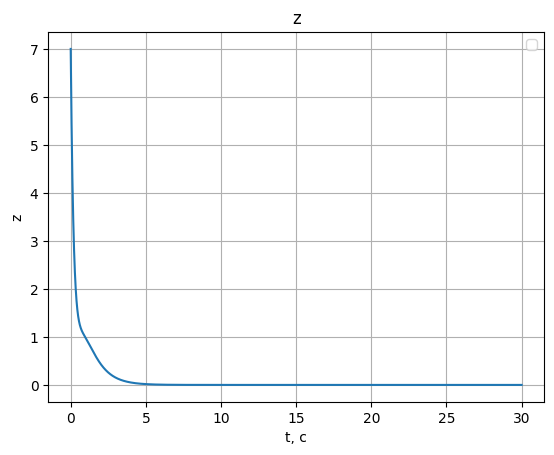

In [361]:
plt.plot(ts, resp.outputs[0])
plt.xlabel('t, c')
plt.ylabel('z')
plt.title("z")
plt.legend()
plt.grid()

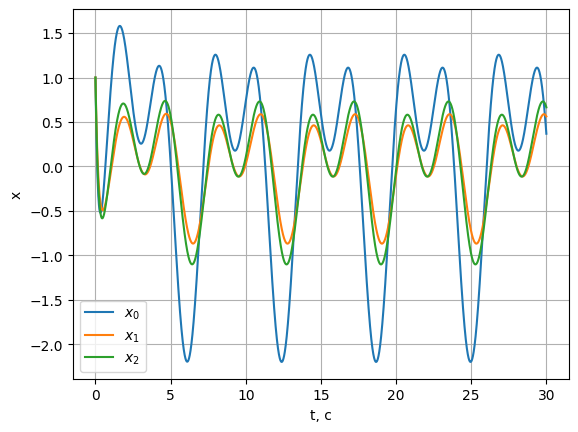

In [357]:
for i in range(task1_A1.shape[0]):
    plt.plot(ts, resp.states[i], label=f'$x_{i}$')
plt.xlabel('t, c')
plt.ylabel('x')
plt.legend()
plt.grid()

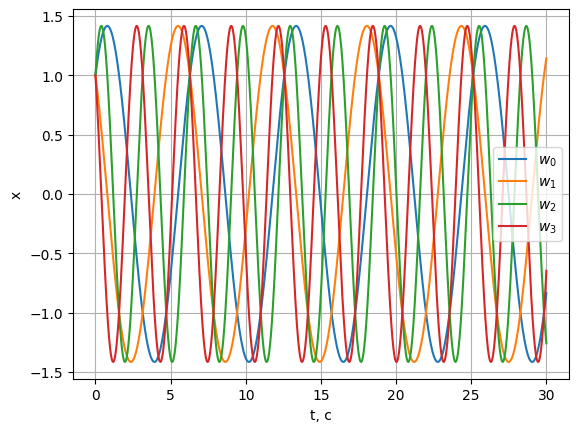

In [358]:
for i in range(task1_A2.shape[0]):
    plt.plot(ts, ws[i], label=f'$w_{i}$')
plt.xlabel('t, c')
plt.ylabel('x')
plt.legend()
plt.grid()

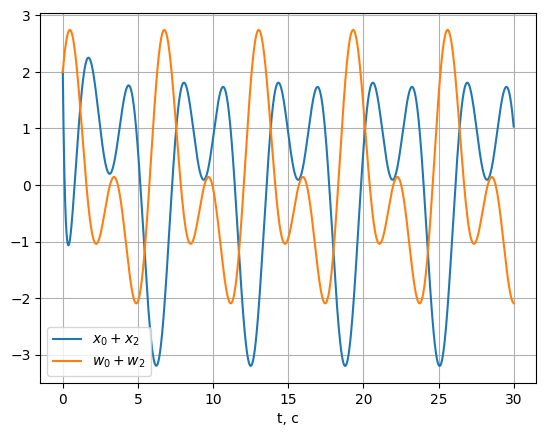

In [359]:
plt.plot(ts, resp.states[0] + resp.states[2], label='$x_0 + x_2$')
plt.plot(ts, ws[0] + ws[2], label='$w_0 + w_2$')
plt.xlabel('t, c')
plt.legend()
plt.grid()

# Задание 3

In [481]:
task3_A1 = np.array([
    [1, 0, 0, 0],
    [0, 2, 0, 0],
    [0, 0, 3, 0],
    [0, 0, 0, 4]
])
task3_B1 = np.array([
    [1],
    [4],
    [7],
    [10]
])
task3_B2 = np.array([
    [1, 0, 0, 0],
    [0, 4, 0, 0],
    [0, 0, 7, 0],
    [0, 0, 0, 10]
])

task3_A2 =  np.array([
    [0, 1, 0, 0],
    [-1, 0, 0, 0],
    [0, 0, 0, 2],
    [0, 0, -2, 0]
])

# z
task3_C2 = np.array([[11, 12, 13, 14]])
task3_D2 = np.array([[14, 13, 12, 11]])

# y
task3_C1 = np.array([[1, 2, 3, 1]])
task3_D1 = np.array([[3, 2, 1, 4]])

In [482]:
check_controllability_eigens(task3_A1, task3_B1)

Eigen values of A:
   [1.]: controllable
   [2.]: controllable
   [3.]: controllable
   [4.]: controllable


In [483]:
eig_vals_A1 = np.linalg.eigvals(task3_A1)
eig_vals_A2 = np.linalg.eigvals(task3_A2)

In [484]:
print(eig_vals_A1, eig_vals_A2)

[1. 2. 3. 4.] [0.+1.j 0.-1.j 0.+2.j 0.-2.j]


In [485]:
print(f'\[A_1 = {a2l.to_ltx(task3_A1, print_out=False)}\]')
print(f'\[A_2 = {a2l.to_ltx(task3_A2, print_out=False)}\]')
print(f'\[B_1 = {a2l.to_ltx(task3_B1, print_out=False)}\]')
print(f'\[B_2 = {a2l.to_ltx(task3_B2, print_out=False)}\]')
print(f'\[C_2 = {a2l.to_ltx(task3_C2, print_out=False)}\]')
print(f'\[D_2 = {a2l.to_ltx(task3_D2, print_out=False)}\]')
print(f'\[C_1 = {a2l.to_ltx(task3_C1, print_out=False)}\]')
print(f'\[D_1 = {a2l.to_ltx(task3_D1, print_out=False)}\]')

\[A_1 = \begin{bmatrix}
  1.00 &  0.00 &  0.00 &  0.00\\
  0.00 &  2.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  3.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  4.00
\end{bmatrix}\]
\[A_2 = \begin{bmatrix}
  0.00 &  1.00 &  0.00 &  0.00\\
 -1.00 &  0.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  2.00\\
  0.00 &  0.00 & -2.00 &  0.00
\end{bmatrix}\]
\[B_1 = \begin{bmatrix}
  1.00\\
  4.00\\
  7.00\\
  10.00
\end{bmatrix}\]
\[B_2 = \begin{bmatrix}
  1.00 &  0.00 &  0.00 &  0.00\\
  0.00 &  4.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  7.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  10.00
\end{bmatrix}\]
\[C_2 = \begin{bmatrix}
  11.00 &  12.00 &  13.00 &  14.00
\end{bmatrix}\]
\[D_2 = \begin{bmatrix}
  14.00 &  13.00 &  12.00 &  11.00
\end{bmatrix}\]
\[C_1 = \begin{bmatrix}
  1.00 &  2.00 &  3.00 &  1.00
\end{bmatrix}\]
\[D_1 = \begin{bmatrix}
  3.00 &  2.00 &  1.00 &  4.00
\end{bmatrix}\]


In [486]:
A_obs = np.block([
    [task3_A1, task3_B2],
    [np.zeros((4, 4)), task3_A2]
])
C_obs = np.block([
    [task3_C1, task3_D1]
])
L, _, _ = control.lqe(A_obs, np.eye(8), C_obs, np.eye(8), 1)
L1, L2 = -L[:4], -L[4:]

print(f'\[L_1 = {a2l.to_ltx(L1, print_out=False)}\]')
print(f'\[L_2 = {a2l.to_ltx(L2, print_out=False)}\]')

Ae = np.block([
    [task3_A1 + L1 @ task3_C1, task3_B2 + L1 @ task3_D1],
    [L2 @ task3_C1, task3_A2 + L2 @ task3_D1]
])
print(f'\[\sigma (A_e) = {a2l.to_ltx(np.linalg.eigvals(Ae), print_out=False)}\]')

\[L_1 = \begin{bmatrix}
  133.89\\
 -451.78\\
  540.59\\
 -884.30
\end{bmatrix}\]
\[L_2 = \begin{bmatrix}
  1.09\\
 -0.90\\
 -0.95\\
  1.04
\end{bmatrix}\]
\[\sigma (A_e) = \begin{bmatrix}
 -7.29 + 0.00j & -3.60 + 0.00j & -0.68 + 1.88j & -0.68 + -1.88j & -1.47 + 0.98j & -1.47 + -0.98j & -1.26 + 0.00j & -1.08 + 0.00j
\end{bmatrix}\]


In [487]:
check_observability_eigens(C_obs, A_obs)

Eigen values of A:
   [1.+0.j]: observable
   [2.+0.j]: observable
   [3.+0.j]: observable
   [4.+0.j]: observable
   [0.+1.j]: observable
   [0.-1.j]: observable
   [0.+2.j]: observable
   [0.-2.j]: observable


In [488]:
K1, K2, ss = get_control_by_state(task3_A1, task3_A2, task3_B1, task3_B2, task3_C2, task3_D2)

Optimization error:  0.0
\[K_1 = \begin{bmatrix}
  35.99 & -73.76 &  92.03 & -40.85
\end{bmatrix}\]
\[spec(A + B_1 K_1) = \begin{bmatrix}
 -6.81 & -3.33 & -2.16 & -1.02
\end{bmatrix}\]
\[K_2 = \begin{bmatrix}
  76.62 & -99.75 &  188.85 &  17.10
\end{bmatrix}\]


In [489]:
A_new = np.block([
    [task3_A1 + task3_B1@K1, np.zeros((4, 4)), np.zeros((4, 4))],
    [np.zeros((4, 4)), task3_A1 + L1@task3_C1, task3_B2 + L1@task3_D1],
    [np.zeros((4, 4)), L2@task3_C1, task3_A2 + L2@task3_D1]
])

B_new = np.block([
    [task3_B2 + task3_B1@K2],
    [np.zeros((4, 4))],
    [np.zeros((4, 4))]
])

C_new = np.block([
    [task3_C1, np.zeros((1, 4)), np.zeros((1, 4))],
    [task3_C1, -task3_C1, -task3_D1],
    [task3_C2, np.zeros((1, 4)), np.zeros((1, 4))]
])
D_new = np.block([
    [task3_D1],
    [task3_D1],
    [task3_D2]
])

reg_mat = np.block([
    [task3_A1 + task3_B1@K1 + L1@task3_C1, task3_B2 + task3_B1@K2 + L1@task3_D1],
    [L2@task3_C2, task3_A2 + L2@task3_D2],
])
print(f'\[\sigma (R) = {a2l.to_ltx(np.round(np.linalg.eigvals(reg_mat), 2), print_out=False)}\]')
print(f'\[\sigma (A_2) = {a2l.to_ltx(np.round(np.linalg.eigvals(task3_A2), 1), print_out=False)}\]')

\[\sigma (R) = \begin{bmatrix}
  2209.88 + 0.00j & -2226.16 + 0.00j & -32.41 + 0.00j &  5.95 + 0.00j & -0.16 + 1.25j & -0.16 + -1.25j &  1.16 + 0.00j & -0.02 + 0.00j
\end{bmatrix}\]
\[\sigma (A_2) = \begin{bmatrix}
  0.00 + 1.00j &  0.00 + -1.00j &  0.00 + 2.00j &  0.00 + -2.00j
\end{bmatrix}\]


In [490]:
ts = get_t(30)
ss = control.ss(A_new, B_new, C_new, D_new)
wss = control.ss(task3_A2, np.zeros((4,1)), np.zeros((1, 4)), 0)
ws = control.forced_response(wss, X0=[1, 1, 1, 1], T=ts).states
resp = control.forced_response(ss, T=ts, X0=[1] * A_new.shape[0], U=ws)

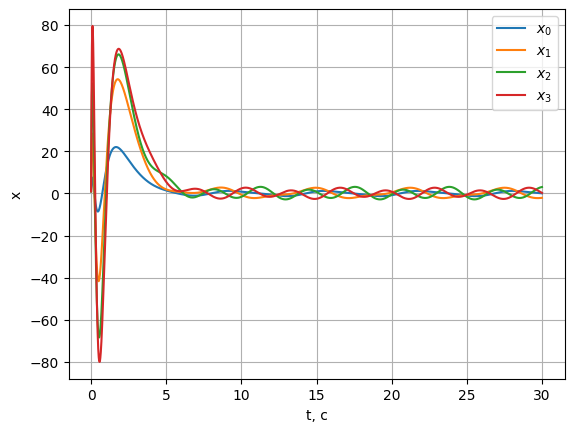

In [491]:
for i in range(4):
    plt.plot(ts, resp.states[i], label=f'$x_{i}$')
plt.xlabel('t, c')
plt.ylabel('x')
plt.legend()
plt.grid()

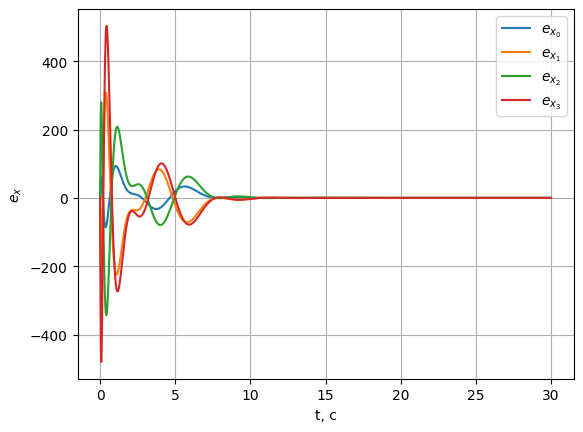

In [492]:
for i in range(4, 8):
    plt.plot(ts, resp.states[i], label='$e_{x_' + str(i % 4) + '}$')
plt.xlabel('t, c')
plt.ylabel('$e_x$')
plt.legend()
plt.grid()

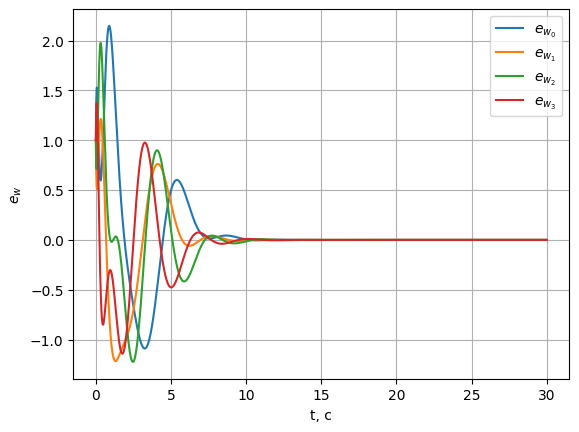

In [493]:
for i in range(8, 12):
    plt.plot(ts, resp.states[i], label='$e_{w_' + str(i % 4) + '}$')
plt.xlabel('t, c')
plt.ylabel('$e_w$')
plt.legend()
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


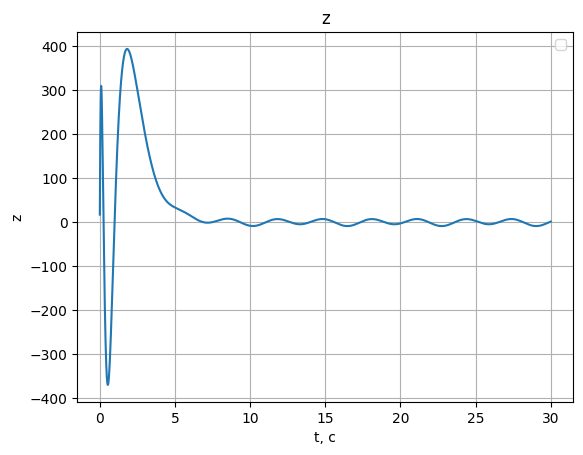

In [494]:
plt.plot(ts, resp.outputs[0])
plt.xlabel('t, c')
plt.ylabel('z')
plt.title("z")
plt.legend()
plt.grid()

# Задание 4

In [497]:
task4_A1 = np.array([
    [1, 0, 0, 0],
    [0, 2, 0, 0],
    [0, 0, 3, 0],
    [0, 0, 0, 4]
])
task4_B1 = np.array([
    [1],
    [4],
    [7],
    [10]
])
task4_B2 = np.array([
    [1, 0, 0, 0],
    [0, 4, 0, 0],
    [0, 0, 7, 0],
    [0, 0, 0, 10]
])

task4_A2 =  np.array([
    [0, 1, 0, 0],
    [-1, 0, 0, 0],
    [0, 0, 0, 2],
    [0, 0, -2, 0]
])

# y
task4_C1 = np.array([[1, 2, 3, 1]])
task4_D1 = np.array([[3, 2, 1, 4]])

# z
task4_C2 = task4_C1
task4_D2 = task4_C1

In [498]:
print(f'\[A_1 = {a2l.to_ltx(task4_A1, print_out=False)}\]')
print(f'\[A_2 = {a2l.to_ltx(task4_A2, print_out=False)}\]')
print(f'\[B_1 = {a2l.to_ltx(task4_B1, print_out=False)}\]')
print(f'\[B_2 = {a2l.to_ltx(task4_B2, print_out=False)}\]')
print(f'\[C_2 = {a2l.to_ltx(task4_C2, print_out=False)}\]')
print(f'\[D_2 = {a2l.to_ltx(task4_D2, print_out=False)}\]')
print(f'\[C_1 = {a2l.to_ltx(task4_C1, print_out=False)}\]')
print(f'\[D_1 = {a2l.to_ltx(task4_D1, print_out=False)}\]')

\[A_1 = \begin{bmatrix}
  1.00 &  0.00 &  0.00 &  0.00\\
  0.00 &  2.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  3.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  4.00
\end{bmatrix}\]
\[A_2 = \begin{bmatrix}
  0.00 &  1.00 &  0.00 &  0.00\\
 -1.00 &  0.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  2.00\\
  0.00 &  0.00 & -2.00 &  0.00
\end{bmatrix}\]
\[B_1 = \begin{bmatrix}
  1.00\\
  4.00\\
  7.00\\
  10.00
\end{bmatrix}\]
\[B_2 = \begin{bmatrix}
  1.00 &  0.00 &  0.00 &  0.00\\
  0.00 &  4.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  7.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  10.00
\end{bmatrix}\]
\[C_2 = \begin{bmatrix}
  1.00 &  2.00 &  3.00 &  1.00
\end{bmatrix}\]
\[D_2 = \begin{bmatrix}
  1.00 &  2.00 &  3.00 &  1.00
\end{bmatrix}\]
\[C_1 = \begin{bmatrix}
  1.00 &  2.00 &  3.00 &  1.00
\end{bmatrix}\]
\[D_1 = \begin{bmatrix}
  3.00 &  2.00 &  1.00 &  4.00
\end{bmatrix}\]


In [499]:
A_obs = np.block([
    [task4_A1, task4_B2],
    [np.zeros((4, 4)), task4_A2]
])
C_obs = np.block([
    [task4_C1, task4_D1]
])
L, _, _ = control.lqe(A_obs, np.eye(8), C_obs, np.eye(8), 1)
L1, L2 = -L[:4], -L[4:]

print(f'\[L_1 = {a2l.to_ltx(L1, print_out=False)}\]')
print(f'\[L_2 = {a2l.to_ltx(L2, print_out=False)}\]')


\[L_1 = \begin{bmatrix}
  133.89\\
 -451.78\\
  540.59\\
 -884.30
\end{bmatrix}\]
\[L_2 = \begin{bmatrix}
  1.09\\
 -0.90\\
 -0.95\\
  1.04
\end{bmatrix}\]


In [500]:
Ae = np.block([
    [task4_A1 + L1 @ task4_C1, task4_B2 + L1 @ task4_D1],
    [L2 @ task4_C1, task4_A2 + L2 @ task4_D1]
])
print(f'\[\sigma (A_e) = {a2l.to_ltx(np.linalg.eigvals(Ae), print_out=False)}\]')
K1, K2, ss = get_control_by_state(task4_A1, task4_A2, task4_B1, task4_B2, task4_C2, task4_D2)
A_new = np.block([
    [task4_A1 + task4_B1@K1, np.zeros((4, 4)), np.zeros((4, 4))],
    [np.zeros((4, 4)), task4_A1 + L1@task4_C1, task4_B2 + L1@task4_D1],
    [np.zeros((4, 4)), L2@task4_C1, task4_A2 + L2@task4_D1]
])

B_new = np.block([
    [task4_B2 + task4_B1@K2],
    [np.zeros((4, 4))],
    [np.zeros((4, 4))]
])

C_new = np.block([
    [task4_C1, np.zeros((1, 4)), np.zeros((1, 4))],
    [task4_C1, -task4_C1, -task4_D1],
    [task4_C2, np.zeros((1, 4)), np.zeros((1, 4))]
])
D_new = np.block([
    [task4_D1],
    [task4_D1],
    [task4_D2]
])

\[\sigma (A_e) = \begin{bmatrix}
 -7.29 + 0.00j & -3.60 + 0.00j & -0.68 + 1.88j & -0.68 + -1.88j & -1.47 + 0.98j & -1.47 + -0.98j & -1.26 + 0.00j & -1.08 + 0.00j
\end{bmatrix}\]
Optimization error:  0.0
\[K_1 = \begin{bmatrix}
  35.99 & -73.76 &  92.03 & -40.85
\end{bmatrix}\]
\[spec(A + B_1 K_1) = \begin{bmatrix}
 -6.81 & -3.33 & -2.16 & -1.02
\end{bmatrix}\]
\[K_2 = \begin{bmatrix}
  76.70 & -99.76 &  188.82 &  17.36
\end{bmatrix}\]


In [501]:
reg_mat = np.block([
    [task4_A1 + task4_B1@K1 + L1@task4_C1, task4_B2 + task4_B1@K2 + L1@task4_D1],
    [L2@task4_C2, task4_A2 + L2@task4_D2],
])
print(f'\[\sigma (R) = {a2l.to_ltx(np.round(np.linalg.eigvals(reg_mat), 2), print_out=False)}\]')
print(f'\[\sigma (A_2) = {a2l.to_ltx(np.round(np.linalg.eigvals(task4_A2), 1), print_out=False)}\]')

\[\sigma (R) = \begin{bmatrix}
  2204.76 + 0.00j & -2249.66 + 0.00j & -6.82 + 0.00j &  2.93 + 0.00j &  1.13 + 0.00j & -0.25 + 1.43j & -0.25 + -1.43j &  0.11 + 0.00j
\end{bmatrix}\]
\[\sigma (A_2) = \begin{bmatrix}
  0.00 + 1.00j &  0.00 + -1.00j &  0.00 + 2.00j &  0.00 + -2.00j
\end{bmatrix}\]


In [502]:
ss = control.ss(A_new, B_new, C_new, D_new)
wss = control.ss(task4_A2, np.zeros((4,1)), np.zeros((1, 4)), 0)
ws = control.forced_response(wss, X0=[1, 1, 1, 1], T=ts).states
resp = control.forced_response(ss, T=ts, X0=[1] * A_new.shape[0], U=ws)

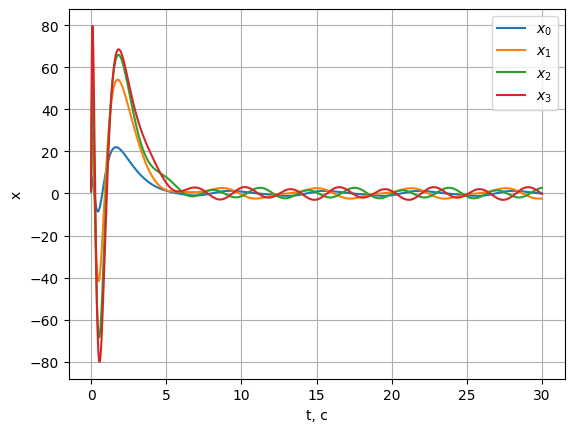

In [503]:
for i in range(4):
    plt.plot(ts, resp.states[i], label=f'$x_{i}$')
plt.xlabel('t, c')
plt.ylabel('x')
plt.legend()
plt.grid()

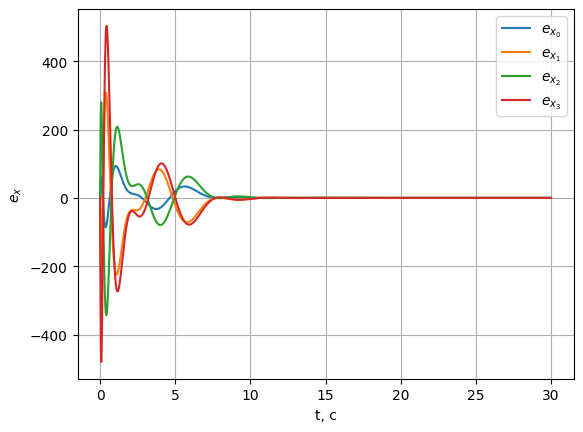

In [504]:
for i in range(4, 8):
    plt.plot(ts, resp.states[i], label='$e_{x_' + str(i % 4) + '}$')
plt.xlabel('t, c')
plt.ylabel('$e_x$')
plt.legend()
plt.grid()

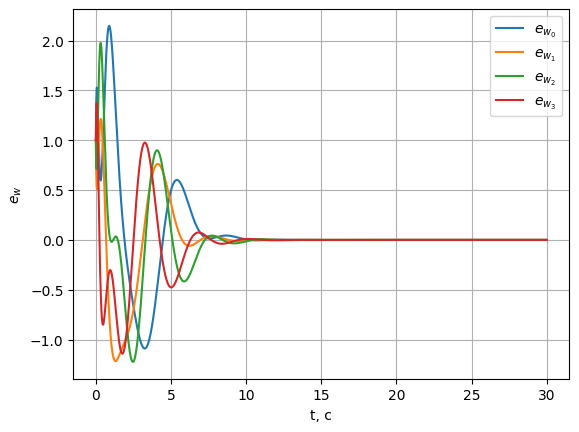

In [505]:
for i in range(8, 12):
    plt.plot(ts, resp.states[i], label='$e_{w_' + str(i % 4) + '}$')
plt.xlabel('t, c')
plt.ylabel('$e_w$')
plt.legend()
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


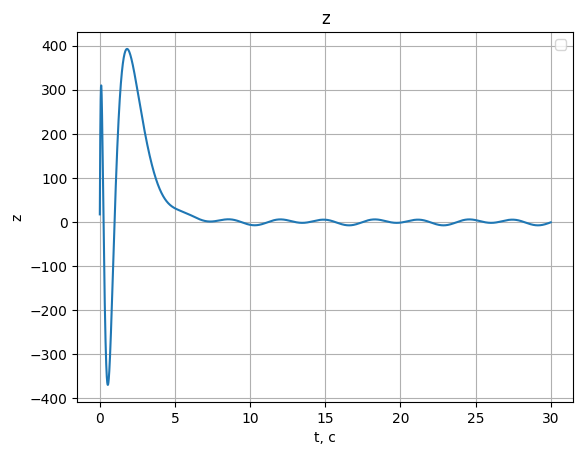

In [507]:
plt.plot(ts, resp.outputs[0])
plt.xlabel('t, c')
plt.ylabel('z')
plt.title("z")
plt.legend()
plt.grid()